In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.regularizers import l1, l2
import numpy as np
import pickle
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Input,Dense, Dropout
np.random.seed(42)
tf.random.set_seed(42)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
def plot_history(history):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    # move everything to +1 to avoid starting on epoch 0
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    # set xlim to 1, len(history.epoch)+1 to avoid starting on epoch 0
    plt.xlim([1, len(history.epoch)+1])
    # set ticks to 2
    plt.xticks(np.arange(1, len(history.epoch)+1))
    plt.grid(True)
    plt.title('Training - Loss Function')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xticks(np.arange(1, len(history.epoch)+1))
    plt.xlim([1, len(history.epoch)+1])
    plt.grid(True)
    plt.title('Train - Accuracy')

In [15]:
# plot_history(history)

1.1

In [16]:
def preprocess_mnist_data(X_train, y_train, X_test, y_test,validation_percentage=0.1):
    num_classes = np.unique(y_train).__len__()
    lenght = X_train.shape[1]
    width = X_train.shape[2]
    print(f"num_classes: {num_classes}, lenght: {lenght}, width: {width}")  
    X_train = X_train.reshape(X_train.shape[0], lenght*width).astype('float32') / 255
    X_test = X_test.reshape(X_test.shape[0], lenght*width).astype('float32') / 255
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    total_num_examples = X_train.shape[0] + X_test.shape[0]
    total_num_validation_examples = int(total_num_examples * validation_percentage)
    X_val = X_test[:total_num_validation_examples]
    y_val = y_test[:total_num_validation_examples]
    X_test = X_test[total_num_validation_examples:]
    y_test = y_test[total_num_validation_examples:]
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [17]:
def load_fashion_mnist_data(validation_percentage=0.1):
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, y_train, X_val, y_val, X_test, y_test, num_classes = preprocess_mnist_data(X_train, y_train, X_test, y_test,validation_percentage)
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes
def load_cifar10_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    num_classes = np.unique(y_train).__len__()
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    X_val = X_train[int(X_train.shape[0]*0.9):]
    y_val = y_train[int(y_train.shape[0]*0.9):]
    X_train = X_train[:int(X_train.shape[0]*0.9)]
    y_train = y_train[:int(y_train.shape[0]*0.9)]
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

def create_model_small(shape,activation='relu', optimizer='adam', 
                 regularization=None, dropout_rate=0.0, architectures=[32,32],num_classes=10):
    model = Sequential([
        Input(shape=shape),
        Conv2D(filters=architectures[0],kernel_size=3,activation=activation,kernel_regularizer=regularization),
        MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
        Dropout(dropout_rate),
        Flatten(),
        Dense(architectures[1],activation=activation),
        Dense(num_classes,activation = 'softmax')
    ])
    model.compile(loss ='categorical_crossentropy', optimizer=optimizer,metrics =['accuracy'])
    return model

def create_model_big(shape,activation='relu', optimizer='adam', 
                 regularization=None, dropout_rate=0.0, architectures=[128,64,32],num_classes=10):
    model = Sequential([
        Input(shape=shape), # image shape is (32, 32, 3)
        Conv2D(architectures[0], (3, 3), activation=activation, padding='same', kernel_regularizer=regularization),
        MaxPooling2D((2, 2)),
        Conv2D(architectures[1], (3, 3), activation=activation, padding='same', kernel_regularizer=regularization),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Conv2D(architectures[1], (3, 3), activation=activation, padding='same', kernel_regularizer=regularization),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(architectures[2], activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss ='categorical_crossentropy', optimizer=optimizer,metrics =['accuracy'])
    return model

In [25]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, y_train, X_val, y_val, X_test, y_test, num_classes= preprocess_mnist_data(X_train, y_train, X_test, y_test)
batch_size = 128
epochs = 20
input_shape = X_train[0].shape

num_classes: 10, lenght: 28, width: 28


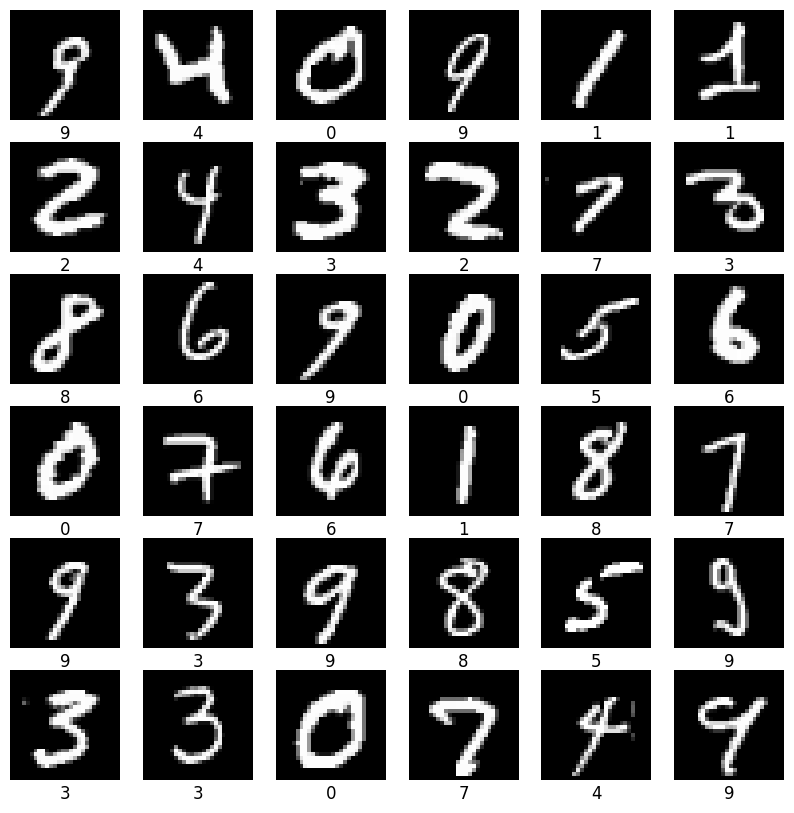

In [27]:
# plot mnist data
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    # reshape to 28x28
    example = X_train[i+19].reshape(28, 28)
    plt.imshow(example, cmap='gray')
    label = np.argmax(y_train[i+19])
    plt.title(label,y=-0.25)
    plt.axis('off')
plt.show()

In [20]:
# total number of examples in both training and testing sets
total_train_examples = X_train.shape[0]
total_test_examples = X_test.shape[0]
print(f"Total number of training examples: {total_train_examples}")
print(f"Total number of testing examples: {total_test_examples}")

Total number of training examples: 60000
Total number of testing examples: 3000


In [21]:
mlp_mnist_model = Sequential([
    Input(shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
mlp_mnist_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = mlp_mnist_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))
test_loss, test_acc = mlp_mnist_model.evaluate(X_test, y_test)
# mlp_mnist_model.summary()

I0000 00:00:1731531711.338319   39450 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731531711.338418   39450 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731531711.338462   39450 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731531711.568250   39450 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731531711.568350   39450 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13

Epoch 1/20


I0000 00:00:1731531713.573115   48025 service.cc:146] XLA service 0x7f379000a7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731531713.573169   48025 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-13 22:01:53.610902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 22:01:53.748074: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


111/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7298 - loss: 0.8851

I0000 00:00:1731531715.836041   48025 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8177 - loss: 0.6062

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc

(0.03808954358100891, 0.9913333058357239)

1.2

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_fashion_mnist_data()

num_classes: 10, lenght: 28, width: 28


In [23]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# adapted from https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide#Labels

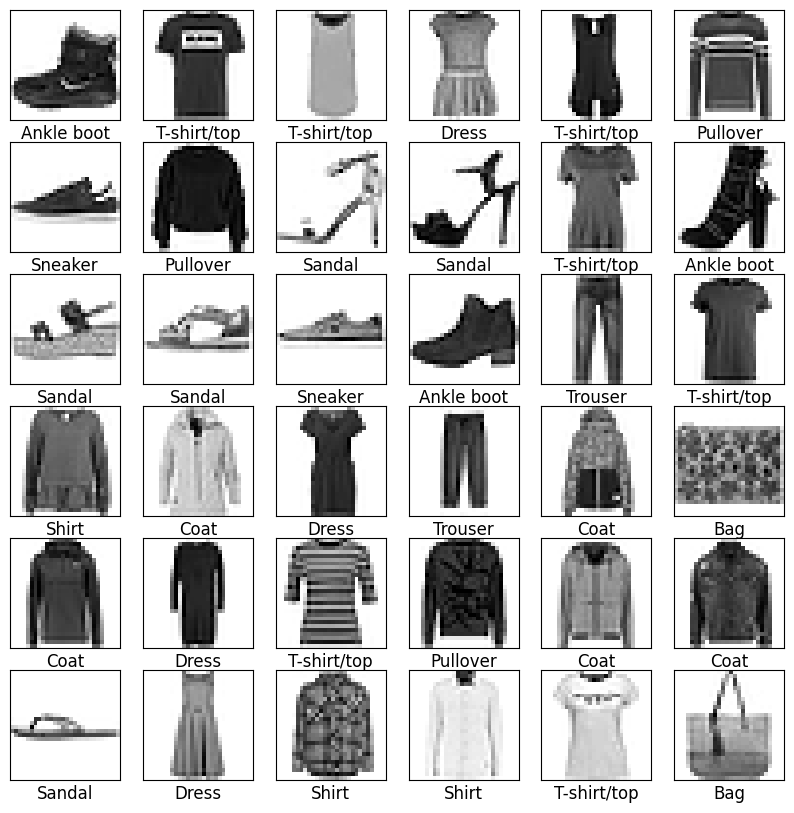

In [24]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([]) # making the x and y axis invisible
    plt.yticks([])
    plt.grid(False)
    image  = X_train[i].reshape((28,28))
    # set in gray scale
    plt.imshow(image, cmap=plt.cm.binary)
    label_index = np.argmax(y_train[i])
    plt.title(labels[label_index],y=-0.25)
plt.show()

In [133]:
fashion_mnist_mlp_model = Sequential([
    Input(shape=input_shape),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

fashion_mnist_mlp_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
batch_size = 128
history = fashion_mnist_mlp_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))
test_loss, test_acc = fashion_mnist_mlp_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7545 - loss: 0.6905 - val_accuracy: 0.8483 - val_loss: 0.4275
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8567 - loss: 0.3954 - val_accuracy: 0.8583 - val_loss: 0.3968
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8689 - loss: 0.3568 - val_accuracy: 0.8589 - val_loss: 0.3936
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8768 - loss: 0.3302 - val_accuracy: 0.8591 - val_loss: 0.3887
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8827 - loss: 0.3167 - val_accuracy: 0.8723 - val_loss: 0.3523
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8880 - loss: 0.3031 - val_accuracy: 0.8733 - val_loss: 0.3466
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8900 - loss: 0.2886 - val_accuracy: 0.8794 - val_loss: 0.3392
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8928 - loss: 0.2818 - val_accuracy: 0.

In [134]:
fashion_mnist_mlp_model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,456 (6.13 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,071,638 (4.09 MB)

CNN of the fashion dataset

In [135]:
image_shape = (28, 28, 1)
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_fashion_mnist_data()
X_train = X_train.reshape(X_train.shape[0],*image_shape) # revert to the original shape
X_test = X_test.reshape(X_test.shape[0],*image_shape)
X_val = X_val.reshape(X_val.shape[0],*image_shape)
X_train.shape

num_classes: 10, lenght: 28, width: 28


(60000, 28, 28, 1)

In [136]:
cnn_model_fashion_mnist = create_model_small(image_shape, architectures=[32,32],num_classes=num_classes)
# TODO check difference (loss='categorical_crossentropy', and sparse_categorical_crossentropy)
# from https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide#Define-the-model
history = cnn_model_fashion_mnist.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val),
)
test_loss, test_acc = cnn_model_fashion_mnist.evaluate(X_test, y_test, verbose=2)	
print(f"Test accuracy: {test_acc}")
cnn_model_fashion_mnist.save('cnn_model_fahsion_mnist.keras')


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7488 - loss: 0.7482 - val_accuracy: 0.8599 - val_loss: 0.4010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8769 - loss: 0.3530 - val_accuracy: 0.8724 - val_loss: 0.3651
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8924 - loss: 0.3063 - val_accuracy: 0.8856 - val_loss: 0.3293
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9018 - loss: 0.2796 - val_accuracy: 0.8904 - val_loss: 0.3124
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9074 - loss: 0.2601 - val_accuracy: 0.8924 - val_loss: 0.3023
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9128 - loss: 0.2435 - val_accuracy: 0.8939 - val_loss: 0.2970
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9174 - loss: 0.2292 - val_accuracy: 0.8960 - val_loss: 0.2926
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9217 - loss: 0.2163 - val_accuracy: 0.

CIFAR-10 dataset

In [137]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_cifar10_data()
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

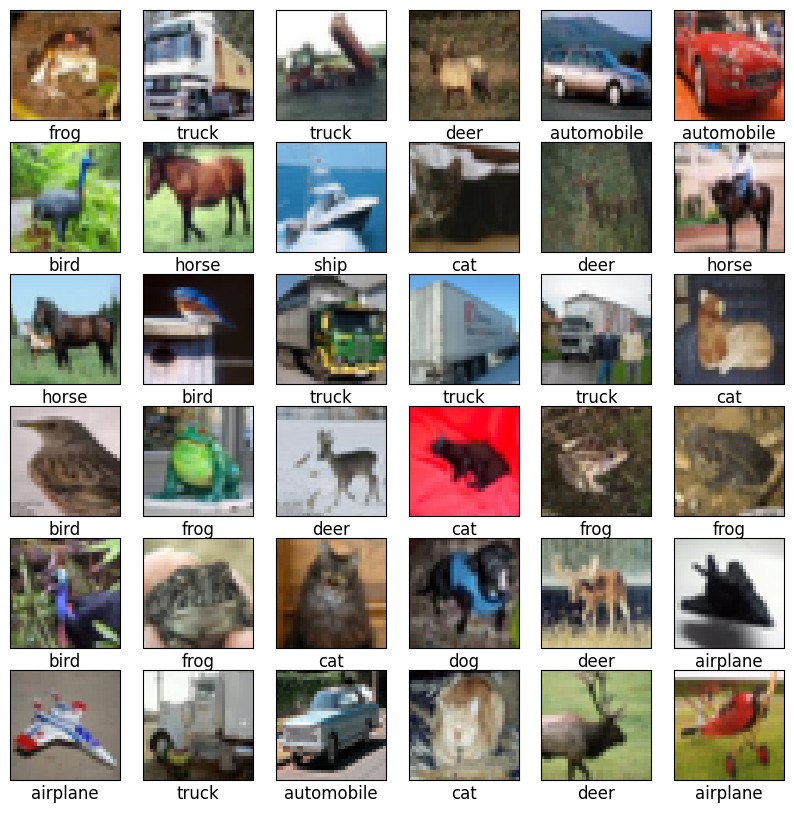

In [138]:
# show the first 36 images
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([]) # making the x and y axis invisible
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((32,32,3)))
    label_index = np.argmax(y_train[i])
    plt.title(labels[label_index],y=-0.25)
plt.show()

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.1986 - loss: 6.4285 - val_accuracy: 0.3872 - val_loss: 1.6706
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4151 - loss: 1.6250 - val_accuracy: 0.4968 - val_loss: 1.4200
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4987 - loss: 1.3961 - val_accuracy: 0.5554 - val_loss: 1.2620
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5581 - loss: 1.2466 - val_accuracy: 0.5920 - val_loss: 1.1456
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6037 - loss: 1.1276 - val_accuracy: 0.6338 - val_loss: 1.0513
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6324 - loss: 1.0462 - val_accuracy: 0.6616 - val_loss: 0.9918
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6517 - loss: 0.9878 - val_accuracy: 0.6886 - val_loss: 0.9205
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6779 - loss: 0.9208 - val_accu

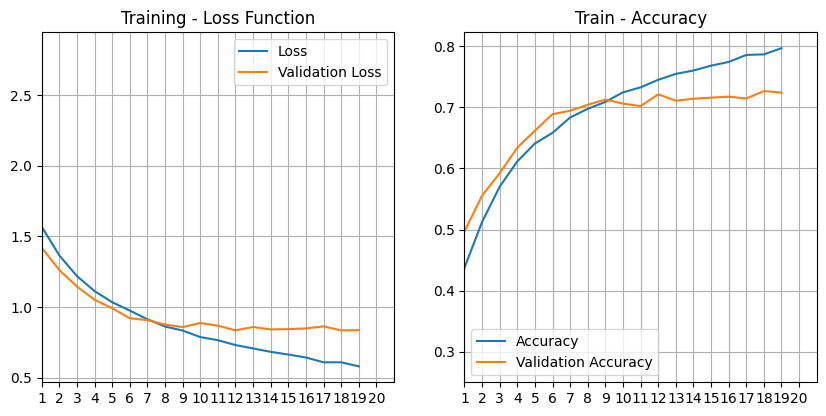

In [140]:
cnn_model_cifar10 = create_model_big(X_train[0].shape, architectures=[256,128,64],num_classes=num_classes,dropout_rate=0.2)
history = cnn_model_cifar10.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val),
)
test_loss, test_acc = cnn_model_cifar10.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")
# cnn_model_cifar10.summary()
plot_history(history)

running tests

In [15]:
initializations = ['he_normal', 'glorot_uniform']
activations = ['relu', 'tanh']
optimizers = ['adam', 'sgd']
regularizations = [None, l2(0.01), l1(0.01)]
dropout_rates = [0.0, 0.25]
architectures = [[32,32], [64,64], [128,128]]

In [16]:
image_shape = (28, 28, 1)
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_fashion_mnist_data()
X_train = X_train.reshape(X_train.shape[0],*image_shape) # revert to the original shape
X_test = X_test.reshape(X_test.shape[0],*image_shape)
X_val = X_val.reshape(X_val.shape[0],*image_shape)
X_train.shape

num_classes: 10, lenght: 28, width: 28


(54000, 28, 28, 1)

In [ ]:
combinations_small = {}
for architecture in architectures:
    for activation in activations:
        for opt in optimizers:
            for reg in regularizations:
                for dropout_rate in dropout_rates:
                    print(f"Training model with activation={activation}, optimizer={opt}, "
                            f"reg={reg}, dropout_rate={dropout_rate}, architecture={architecture}")
                    model = create_model_small(shape=X_train[0].shape, activation=activation, optimizer=opt, 
                                            regularization=reg, dropout_rate=dropout_rate,architectures=architecture)
                    history = model.fit(
                            X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(X_val, y_val),
                        )
                    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)	
                    print("\nTest accuracy:", test_acc)
                    combinations_small[(*architecture, activation, opt, reg, dropout_rate)] = {'test_acc': test_acc, 'history': history}
with open(f'combinations_small_{epochs}_epochs.pkl', 'wb') as f:
    pickle.dump(combinations_small, f)


Training model with activation=relu, optimizer=adam, reg=None, dropout_rate=0.0, architecture=[32, 32]
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7261 - loss: 0.8141 - val_accuracy: 0.8645 - val_loss: 0.3863
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8711 - loss: 0.3685 - val_accuracy: 0.8833 - val_loss: 0.3368
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8907 - loss: 0.3203 - val_accuracy: 0.8978 - val_loss: 0.2986
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9001 - loss: 0.2799 - val_accuracy: 0.8957 - val_loss: 0.2933
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9076 - loss: 0.2644 - val_accuracy: 0.9018 - val_loss: 0.2750
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9133 - loss: 0.2398 - val_accuracy: 0.8953 - val_loss: 0.2800
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9203 - loss: 0.2229 - val_accuracy: 0.9018 - val_loss: 0.2732
E

2024-11-06 15:12:13.091770: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_204', 4 bytes spill stores, 4 bytes spill loads



422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7815 - loss: 0.6288 - val_accuracy: 0.8857 - val_loss: 0.3183
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8948 - loss: 0.2933 - val_accuracy: 0.8970 - val_loss: 0.2759
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9135 - loss: 0.2392 - val_accuracy: 0.9073 - val_loss: 0.2566
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9286 - loss: 0.1983 - val_accuracy: 0.9100 - val_loss: 0.2527
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9424 - loss: 0.1632 - val_accuracy: 0.9082 - val_loss: 0.2563
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9508 - loss: 0.1404 - val_accuracy: 0.9155 - val_loss: 0.2406
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1112 - val_accuracy: 0.9163 - val_loss: 0.2350
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9675 - loss: 0.0970 - val_accuracy: 0.9142 - val

In [3]:
with open(f'combinations_small_{epochs}_epochs.pkl', 'rb') as f:
    combinations_small = pickle.load(f)

I0000 00:00:1730910826.743747  261027 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730910826.743848  261027 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730910826.743881  261027 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730910826.862890  261027 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730910826.862970  261027 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-06

In [20]:
# get the top K highest accuracy
combinations_small = {k: v for k, v in sorted(combinations_small.items(), key=lambda item: item[1]['test_acc'], reverse=True)}
top_k = 3
top_k_combinations_small = dict(list(combinations_small.items())[:top_k])
top_k_combinations_small

{(128,
  128,
  'relu',
  'adam',
  0.25): {'test_acc': 0.9150000214576721,
  'history': <keras.src.callbacks.history.History at 0x7fb141e4c110>},
 (128, 128, 'tanh', 'adam', None, 0.0): {'test_acc': 0.914900004863739,
  'history': <keras.src.callbacks.history.History at 0x7fb141a46f10>},
 (128, 128, 'relu', 'adam', None, 0.0): {'test_acc': 0.9147999882698059,
  'history': <keras.src.callbacks.history.History at 0x7fb141e26d10>}}

In [21]:
top_k_combinations_small.keys()

dict_keys([(128, 128, 'relu', 'adam', <keras.src.regularizers.regularizers.L2 object at 0x7fb28c170d50>, 0.25), (128, 128, 'tanh', 'adam', None, 0.0), (128, 128, 'relu', 'adam', None, 0.0)])

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_cifar10_data()
shape = X_train[1:].shape
# train models with the top k combinations
cifar10_top_k_results_small = {}
for (layer1_arch, layer2_arch, activation, opt, reg, dropout_rate) in top_k_combinations_small.keys():
    print(f"Training model with activation={activation}, optimizer={opt}, "
            f"reg={reg}, dropout_rate={dropout_rate}")
    architectures = [layer1_arch, layer2_arch]
    model = create_model_small(shape=X_train[0].shape,activation=activation, optimizer=opt, 
                            regularization=reg, dropout_rate=dropout_rate, architectures=architectures)
    history = model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_val, y_val),
        )
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)	
    print("\nTest accuracy:", test_acc)
    cifar10_top_k_results_small[(*architectures,activation, opt, reg, dropout_rate)] = {'test_acc': test_acc, 'history': history}
cifar10_top_k_results_small

Training model with activation=relu, optimizer=adam, reg=<keras.src.regularizers.regularizers.L2 object at 0x7fb28c170d50>, dropout_rate=0.25
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.2758 - loss: 54.0909 - val_accuracy: 0.4770 - val_loss: 1.5612
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5050 - loss: 1.4550 - val_accuracy: 0.5018 - val_loss: 1.4439
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5752 - loss: 1.2735 - val_accuracy: 0.5504 - val_loss: 1.3510
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6194 - loss: 1.1353 - val_accuracy: 0.5510 - val_loss: 1.3714
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6616 - loss: 1.0174 - val_accuracy: 0.5682 - val_loss: 1.3539
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7016 - loss: 0.9043 - val_accuracy: 0.5734 - val_loss: 1.3686
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7273 - loss: 0.8212 - 

2024-11-06 17:29:44.864696: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_205', 4 bytes spill stores, 4 bytes spill loads



352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1022 - loss: 3.0239 - val_accuracy: 0.0950 - val_loss: 2.3043
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0961 - loss: 2.3087 - val_accuracy: 0.0976 - val_loss: 2.3078
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0976 - loss: 2.3100 - val_accuracy: 0.1064 - val_loss: 2.3066
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1010 - loss: 2.3095 - val_accuracy: 0.0970 - val_loss: 2.3101
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0985 - loss: 2.3095 - val_accuracy: 0.1058 - val_loss: 2.3062
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0995 - loss: 2.3098 - val_accuracy: 0.0970 - val_loss: 2.3123
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0999 - loss: 2.3111 - val_accuracy: 0.0970 - val_loss: 2.3129
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0971 - loss: 2.3101 - val_accuracy: 0.0958 - val

{(128,
  128,
  'relu',
  'adam',
  0.25): {'test_acc': 0.5557000041007996,
  'history': <keras.src.callbacks.history.History at 0x7fb1c8779950>},
 (128, 128, 'tanh', 'adam', None, 0.0): {'test_acc': 0.10000000149011612,
  'history': <keras.src.callbacks.history.History at 0x7fb1a4259a10>},
 (128, 128, 'relu', 'adam', None, 0.0): {'test_acc': 0.5300999879837036,
  'history': <keras.src.callbacks.history.History at 0x7fb17c90e490>}}

In [26]:
with open(f'cifar10_top_k_small_results_{epochs}_epochs.pkl', 'wb') as f:
    pickle.dump(cifar10_top_k_results_small, f)
# load 
# with open(f'cifar10_top_k_small_results_{epochs}_epochs.pkl', 'rb') as f:
#     cifar10_top_k_results_small = pickle.load(f)

In [29]:
image_shape = (28, 28, 1)
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_fashion_mnist_data()
X_train = X_train.reshape(X_train.shape[0],*image_shape) # revert to the original shape
X_test = X_test.reshape(X_test.shape[0],*image_shape)
X_val = X_val.reshape(X_val.shape[0],*image_shape)
X_train.shape

num_classes: 10, lenght: 28, width: 28


(54000, 28, 28, 1)

In [30]:
combinations_big = {}
architectures = [[128,64,32], [256,128,64], [512,256,128]]
for architecture in architectures:
    for activation in activations:
        for opt in optimizers:
            for reg in regularizations:
                for dropout_rate in dropout_rates:
                    print(f"Training model with activation={activation}, optimizer={opt}, "
                            f"reg={reg}, dropout_rate={dropout_rate}")
                    model = create_model_big(shape=X_train[0].shape, activation=activation, optimizer=opt, 
                                            regularization=reg, dropout_rate=dropout_rate)
                    history = model.fit(
                            X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(X_val, y_val),
                        )
                    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)	
                    print("\nTest accuracy:", test_acc)
                    combinations_big[(*architecture, activation, opt, reg, dropout_rate)] = {'test_acc': test_acc, 'history': history}
with open(f'combinations_big_{epochs}_epochs.pkl', 'wb') as f:
    pickle.dump(combinations_big, f)

Training model with activation=relu, optimizer=adam, reg=None, dropout_rate=0.0
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6744 - loss: 0.9021 - val_accuracy: 0.8552 - val_loss: 0.3930
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8703 - loss: 0.3604 - val_accuracy: 0.8843 - val_loss: 0.3279
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8873 - loss: 0.3028 - val_accuracy: 0.8915 - val_loss: 0.3034
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9021 - loss: 0.2702 - val_accuracy: 0.9023 - val_loss: 0.2709
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9107 - loss: 0.2486 - val_accuracy: 0.9020 - val_loss: 0.2731
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9194 - loss: 0.2246 - val_accuracy: 0.9040 - val_loss: 0.2621
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9249 - loss: 0.2084 - val_accuracy: 0.9120 - val_loss: 0.2442
Epoch 8/10
422/422 ━━━━

In [31]:
# get the top K highest accuracy
combinations_big = {k: v for k, v in sorted(combinations_big.items(), key=lambda item: item[1]['test_acc'], reverse=True)}
top_k = 5
top_k_combinations_big = dict(list(combinations_big.items())[:top_k])
top_k_combinations_big

{(256, 128, 64, 'relu', 'adam', None, 0.25): {'test_acc': 0.9139999747276306,
  'history': <keras.src.callbacks.history.History at 0x7f81a86dfdd0>},
 (128, 64, 32, 'relu', 'adam', None, 0.0): {'test_acc': 0.913100004196167,
  'history': <keras.src.callbacks.history.History at 0x7f82cc7d8750>},
 (256, 128, 64, 'relu', 'adam', None, 0.0): {'test_acc': 0.913100004196167,
  'history': <keras.src.callbacks.history.History at 0x7f81b006e3d0>},
 (256, 128, 64, 'tanh', 'adam', None, 0.0): {'test_acc': 0.9128999710083008,
  'history': <keras.src.callbacks.history.History at 0x7f810054dfd0>},
 (128, 64, 32, 'relu', 'adam', None, 0.25): {'test_acc': 0.9110999703407288,
  'history': <keras.src.callbacks.history.History at 0x7f82cc33b510>}}

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_cifar10_data()
shape = X_train[1:].shape
# train models with the top k combinations
cifar10_top_k_results_big = {}
for (layer1,layer2,layers3,activation, opt, reg, dropout_rate) in top_k_combinations_big.keys():
    print(f"Training model with activation={activation}, optimizer={opt}, "
            f"reg={reg}, dropout_rate={dropout_rate}")
    architectures = [layer1,layer2,layers3]
    model = create_model_small(shape=X_train[0].shape,activation=activation, optimizer=opt, 
                            regularization=reg, dropout_rate=dropout_rate, architectures=architectures)
    history = model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_val, y_val),
        )
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)	
    print("\nTest accuracy:", test_acc)
    cifar10_top_k_results_big[(*architectures,activation, opt, reg, dropout_rate)] = {'test_acc': test_acc, 'history': history}
with open(f'cifar10_top_k_big_results_{epochs}_epochs.pkl', 'wb') as f:
    pickle.dump(cifar10_top_k_results_big, f)
cifar10_top_k_results_big

Training model with activation=relu, optimizer=adam, reg=None, dropout_rate=0.25
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3003 - loss: 47.9614
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5168 - loss: 1.3678
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5822 - loss: 1.1863
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6201 - loss: 1.0756
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6534 - loss: 0.9866
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6935 - loss: 0.8677
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7204 - loss: 0.7945
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7365 - loss: 0.7498
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7680 - loss: 0.6668
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7779 - loss: 0.6362
313/313 - 1s - 4ms/step - accuracy: 0.5658 - loss: 1.520

{(256, 128, 64, 'relu', 'adam', None, 0.25): {'test_acc': 0.5658000111579895,
  'history': <keras.src.callbacks.history.History at 0x7f801c5b1490>},
 (128, 64, 32, 'relu', 'adam', None, 0.0): {'test_acc': 0.5464000105857849,
  'history': <keras.src.callbacks.history.History at 0x7f80242e18d0>},
 (256, 128, 64, 'relu', 'adam', None, 0.0): {'test_acc': 0.5519000291824341,
  'history': <keras.src.callbacks.history.History at 0x7f800c77b290>},
 (256, 128, 64, 'tanh', 'adam', None, 0.0): {'test_acc': 0.10000000149011612,
  'history': <keras.src.callbacks.history.History at 0x7f800c5e8a10>},
 (128, 64, 32, 'relu', 'adam', None, 0.25): {'test_acc': 0.3463999927043915,
  'history': <keras.src.callbacks.history.History at 0x7f800c239c50>}}